In [42]:
! pip install opencv-python
! pip install ftfy regex tqdm
! pip install streamlit
! pip install torchray

In [43]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from model import build_model
from clip_ import load, tokenize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import streamlit as st
from torchray.attribution.grad_cam import grad_cam
from matplotlib import rc
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib

In [44]:
torch.cuda.is_available()

True

In [45]:
def interpret_vit(image, text, model, device, neg_saliency=False, index=None):

    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    similarity = image_features_new[0].dot(text_features_new[0])
    
    if neg_saliency:
        objective = 1-similarity
    else:
        objective = similarity
        
    print(objective)
    #model.zero_grad()
    model.visual.eval()
    model.visual.zero_grad()
    objective.backward(retain_graph=True)

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    for blk in image_attn_blocks:
        grad = blk.attn_grad
        cam = blk.attn_probs
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.clamp(min=0).mean(dim=0)
        R += torch.matmul(cam, R)
    R[0, 0] = 0
    image_relevance = R[0, 1:]

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    #return vis
#     plt.show()

In [46]:
st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_rn, preprocess = load("RN50", device=device, jit=False)

def interpret_rn(image, text, model, device, neg_saliency=False, index=None):   
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    if neg:
        objective = -text_features_new
    else:
        objective = text_features_new
        
    objective = (objective * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), objective, saliency_layer=layer)
        
#     image_relevance = grad_cam(model.visual, image.type(model.dtype), image_features, saliency_layer=layer)

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    #return vis

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-B/32", device=device, jit=False)

In [48]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [49]:
def sim_score(model, image, texts):
        texts = tokenize(texts).to(device)
        logits_per_image, logits_per_text = model(image, texts)
        probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

        return probs[0]

In [52]:
root = "/scratch/students/2021-fall-sp-mamooler/sem_project_IVRL/Ringier_Project/Images/"
img_ids = ['happy_woman.jpg', "horse&dog.jpg", "horse&dog.jpg", "vase_or_face.png", "vase_or_face.png", "duck-rabbit.jpeg", "duck-rabbit.jpeg"]
text_lists = ["a woman with green shirt", "a horse", "a dog", "two faces looking at each other", "a white vase", "a rabbit", "a duck"]

model_types = ["ViT", "RN50"]

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
    CenterCrop(size=(224, 224)),
        ToTensor()])
print(preprocess)

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f79571a1050>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


tensor(0.2598, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7402, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.2683, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7314, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.2395, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7607, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.2947, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7051, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.2279, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7720, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.2507, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)
tensor(0.7490, device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)
tensor(0.3071, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward>)


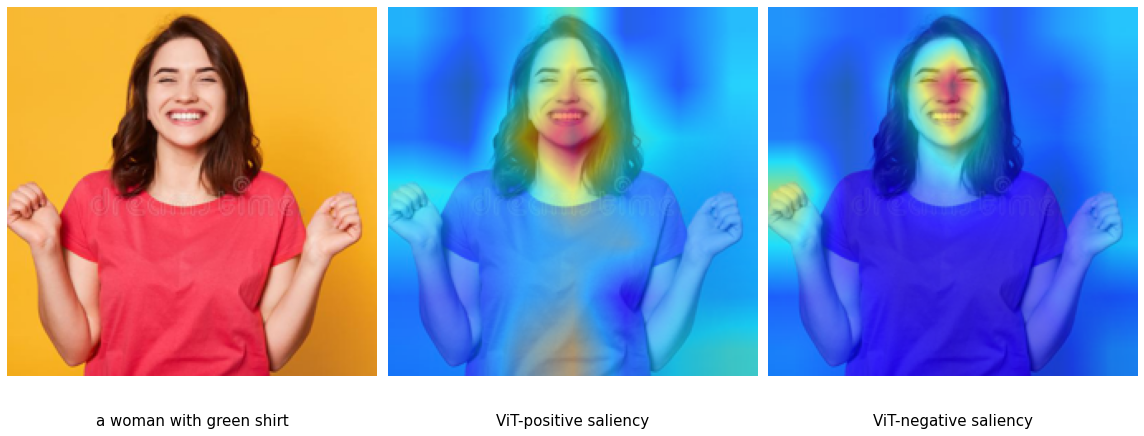

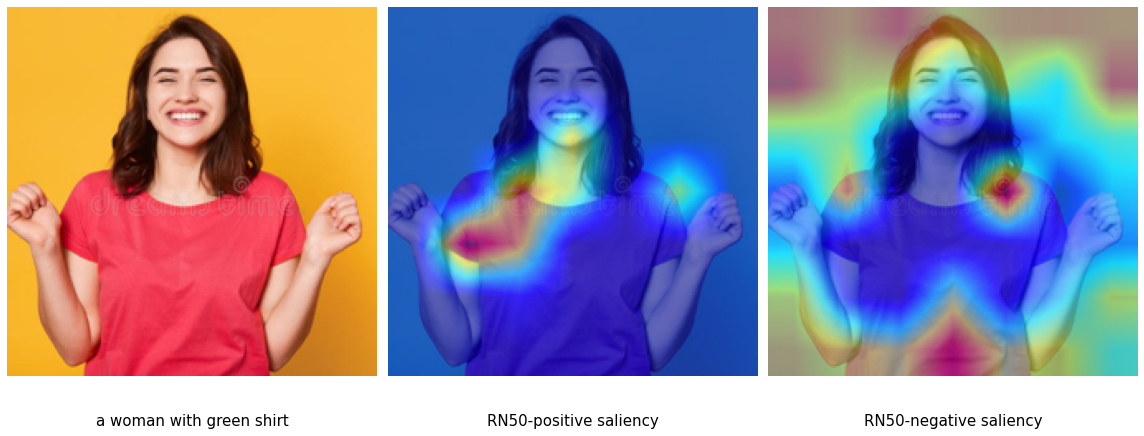

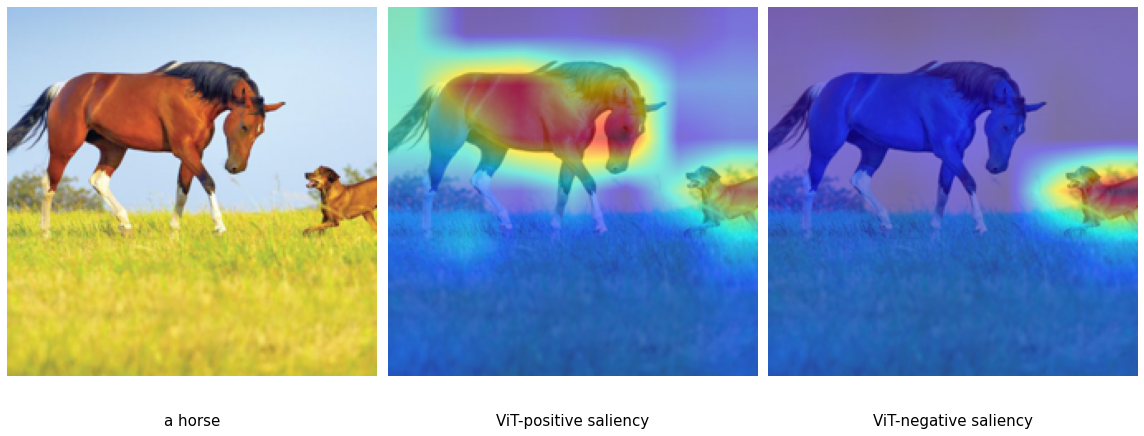

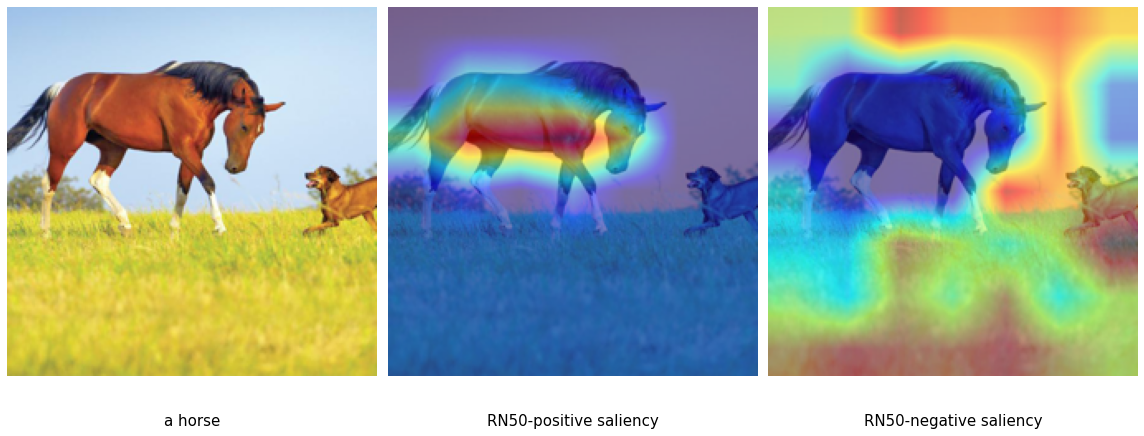

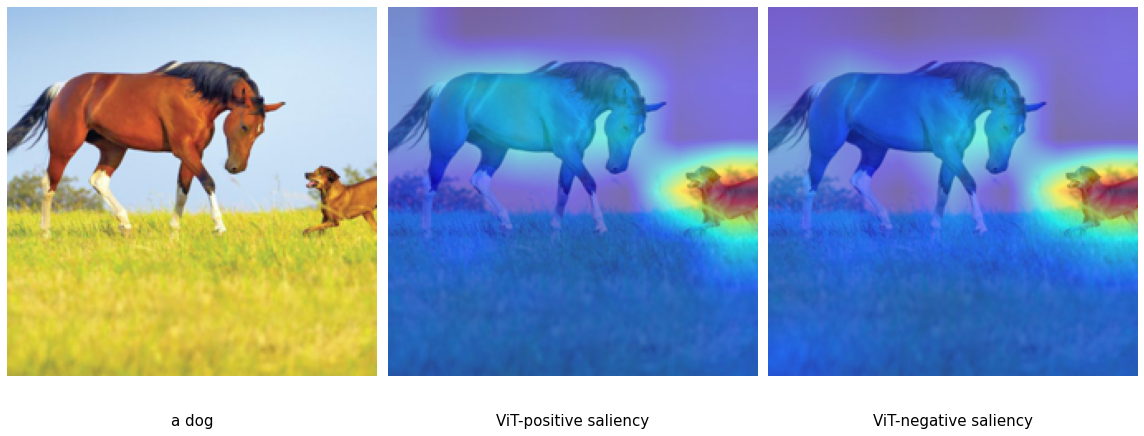

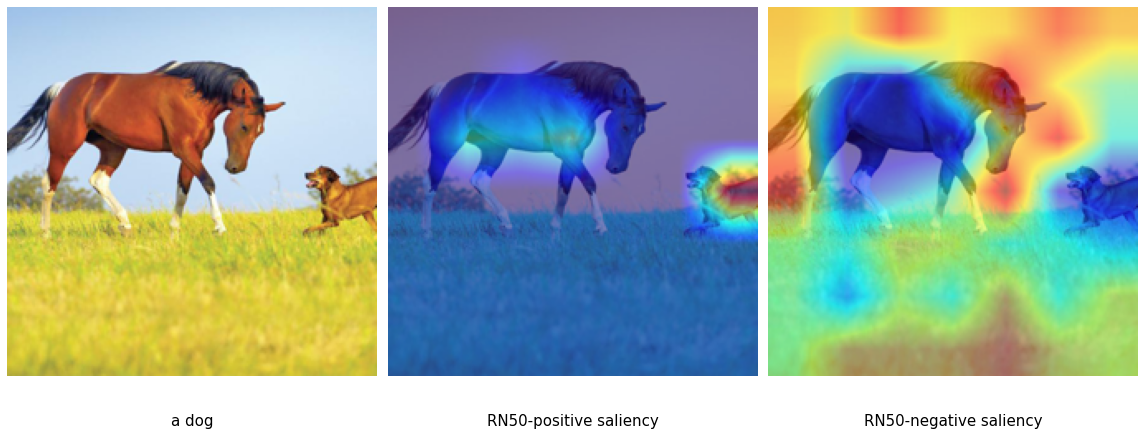

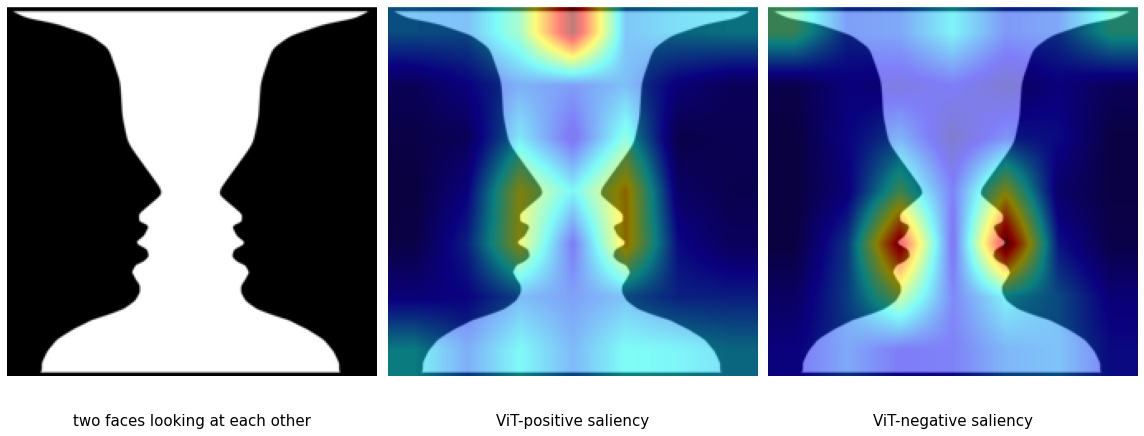

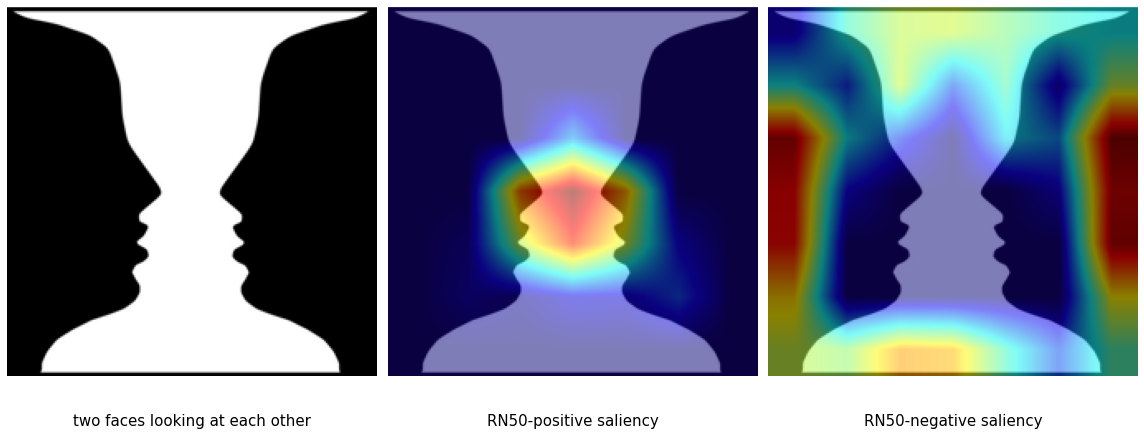

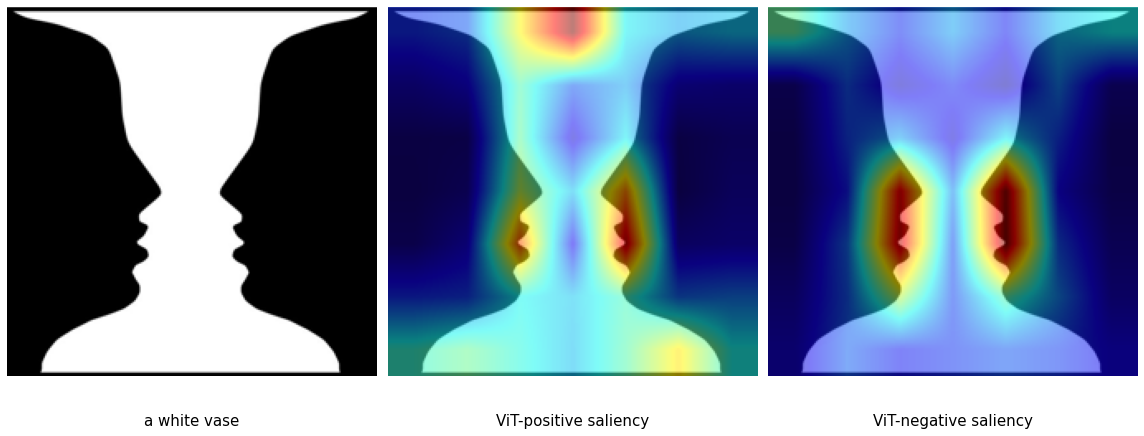

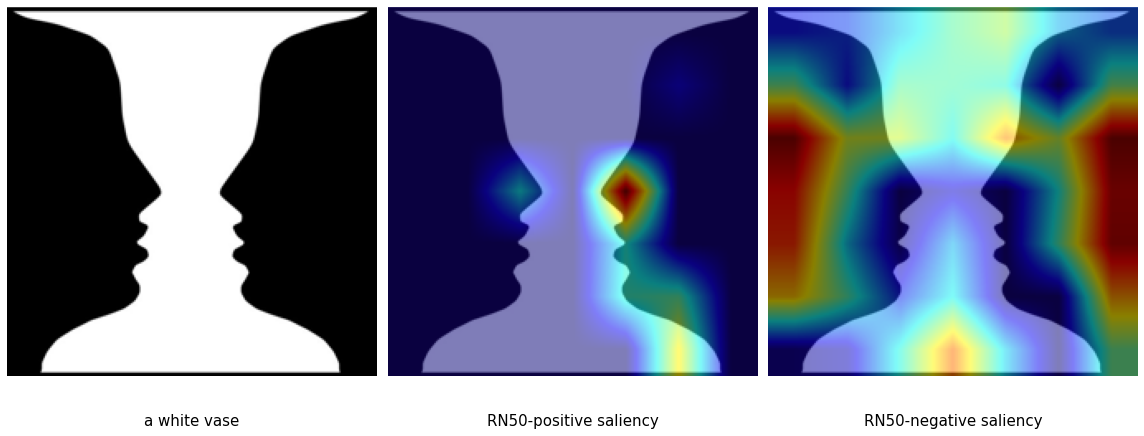

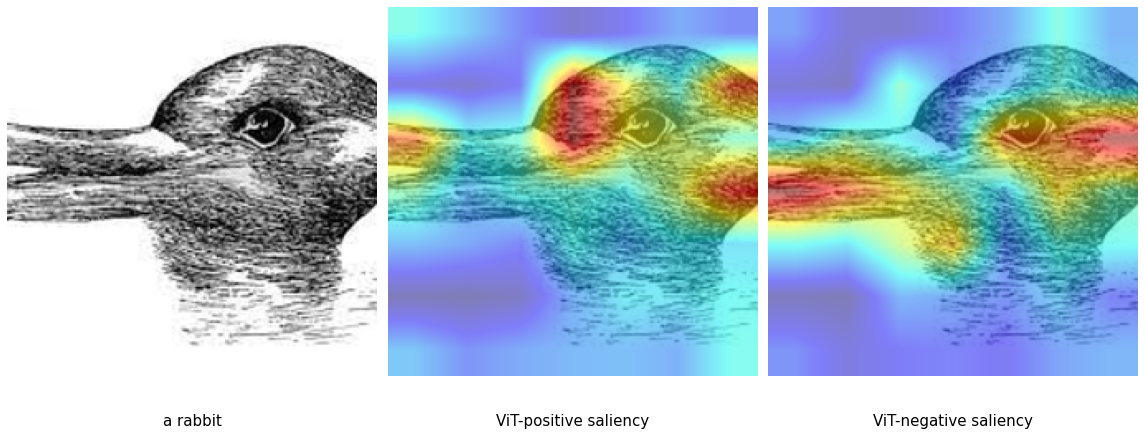

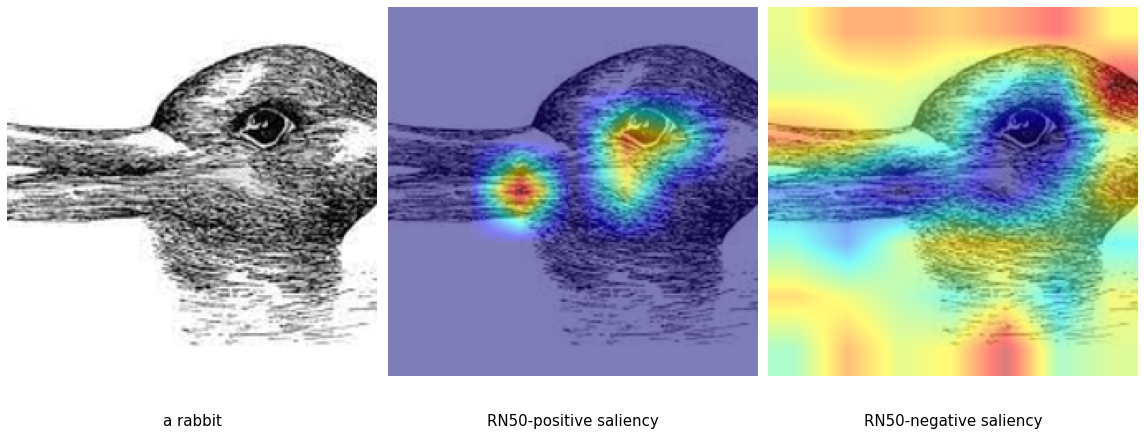

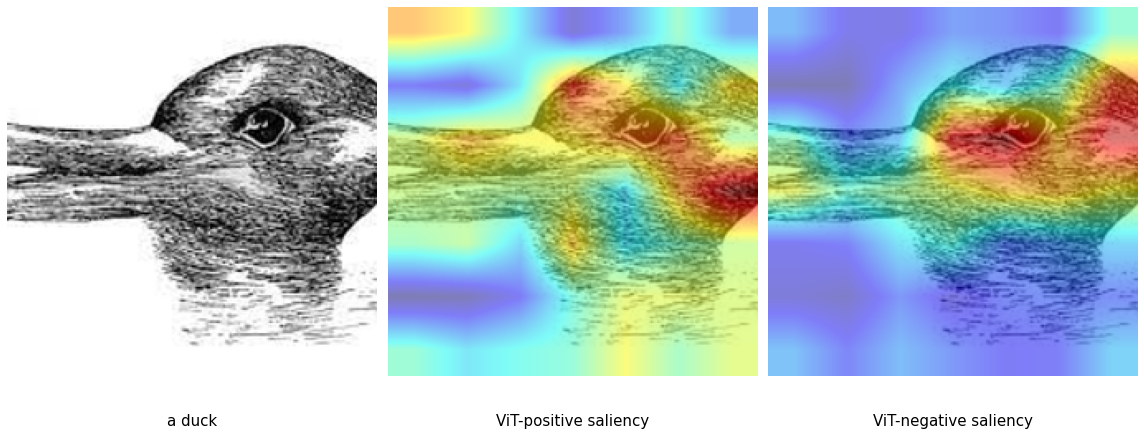

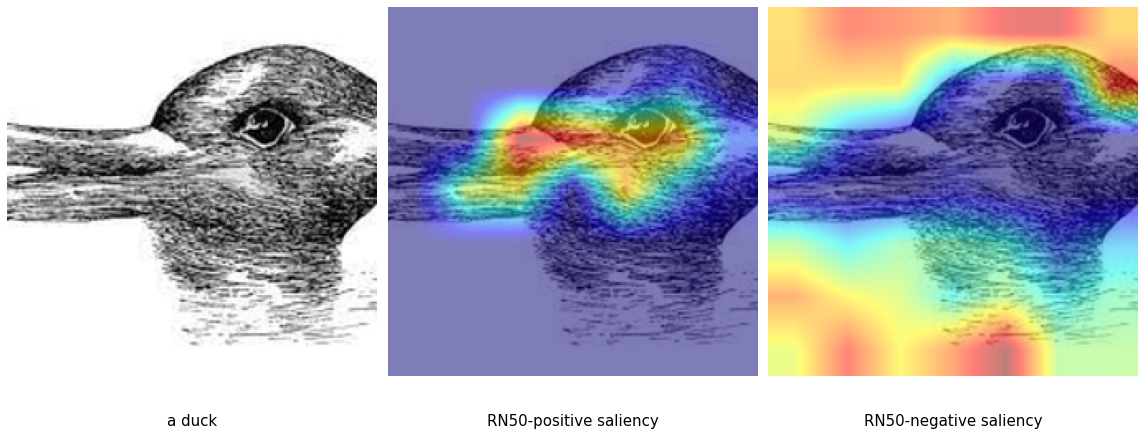

In [54]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))

for id_, img_id in enumerate(img_ids):
    for model_id, model_type in enumerate(model_types):
        
                t_text = text_lists[id_]
                img_path =  os.path.join(root, img_id )
                image = ori_preprocess(Image.open(img_path))
                
                plt.figure(figsize=(16, 16))
                plt.tight_layout()
                plt.subplot(131)
                plt.imshow(image.permute(1, 2, 0))
                plt.axis('off')
               
                plt.title(t_text, **font, y=-0.15)
                
                image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

                subplot = 132
                
                t_text = tokenize(t_text).to(device)
                
                for n,neg in enumerate([False, True]):
                    plt.subplot(subplot+n)
                    if model_type=="ViT":
                        #similarities = sim_score(model, image, texts)
                        interpret_vit(model=model, image=image, text=t_text, device=device, neg_saliency=neg, index=0)

                    else:
                        #similarities = sim_score(model_rn, image, texts)
                        interpret_rn(model=model_rn, image=image, text=t_text, device=device, index=0)

                    if neg:
                        caption = f"{model_type}-negative saliency"
                    else:
                        caption = f"{model_type}-positive saliency"

                    plt.axis('off')
                    plt.title(caption, **font,y=-0.15)
                    plt.tight_layout()
                    #dir_path = f'saliency_vis/global_vis/'
                    #if not os.path.exists(dir_path):
                    #    os.mkdir(dir_path)
                    #plt.savefig(f'{dir_path}{model_type}_{img_id}.jpg', bbox_inches='tight')


In [ ]:
    """"
    texts = tokenize(texts).to(device)
    image_features = model.encode_image(image)
    text_features = model.encode_text(texts)
    image_features = image_features.norm(dim=-1, keepdim=True)
    text_features = text_features.norm(dim=-1, keepdim=True)
    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarities[0]
    """"